# 🔬 Hypothesis Testing Framework
## Agricultural Earnings Forecast - Statistical Validation

---

This notebook performs comprehensive statistical testing to validate the Agricultural Earnings Forecast models.

**Research Question:** Can we accurately predict agricultural earnings by combining independent price and yield forecasting models?

**Contents:**
1. Setup & Data Loading
2. Test 1: Price Model vs Baseline (Diebold-Mariano)
3. Test 2: Yield Model vs Historical Average (Paired t-test)
4. Test 3: Integration Model Added Value (Bootstrap)
5. Test 4: Uncertainty Calibration (Binomial)
6. Test 5: Feature Importance Significance (Permutation)
7. Test 6: Temporal Stability (Kruskal-Wallis)
8. Test 7: Residual Diagnostics
9. Test 8: Economic Significance
10. Summary & Conclusions

---
## 1. Setup & Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Statistical tests
from scipy import stats
from scipy.stats import (
    t, ttest_rel, shapiro, binomtest, 
    f_oneway, kruskal, norm
)
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan

# ML libraries
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries loaded successfully")
print(f"Notebook executed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries loaded successfully
Notebook executed: 2025-11-30 16:06:45


### Load Data & Models

**Note:** Replace these with your actual data loading functions

In [2]:
# TODO: Replace with actual data loading
# Example structure:

# Load price data
# df_price = pd.read_csv('../data/features_P-barley-monthly.csv')
# df_price['date'] = pd.to_datetime(df_price['date'])

# Load yield data
# df_yield = pd.read_csv('../data/features_Y-barley.csv')

# Load predictions from trained models
# price_predictions = np.load('../results/price_predictions.npy')
# yield_predictions = np.load('../results/yield_predictions.npy')
# integration_predictions = np.load('../results/integration_predictions.npy')

# For demonstration, create synthetic data
print("⚠️  Using synthetic data for demonstration")
print("Replace this cell with actual data loading code")

n_samples = 64  # 64 months overlap

# Simulated test data
np.random.seed(42)
actual_prices = np.random.normal(1.3, 0.2, n_samples)
price_model_pred = actual_prices + np.random.normal(0, 0.1, n_samples)
price_baseline_pred = np.roll(actual_prices, 1)  # Naive forecast

actual_yields = np.random.normal(3.0, 0.4, 21)
yield_model_pred = actual_yields + np.random.normal(0, 0.2, 21)
yield_baseline_pred = np.array([actual_yields[:5].mean()] * 21)  # Historical avg

actual_earnings = actual_prices[:n_samples] * 1000 * 3.0  # Simplified
integration_pred = price_model_pred[:n_samples] * 1000 * 3.0 + np.random.normal(0, 50, n_samples)
simple_multiplication = price_model_pred[:n_samples] * 1000 * 3.0

print(f"\n📊 Data shapes:")
print(f"  Price samples: {len(actual_prices)}")
print(f"  Yield samples: {len(actual_yields)}")
print(f"  Integration samples: {len(actual_earnings)}")

⚠️  Using synthetic data for demonstration
Replace this cell with actual data loading code

📊 Data shapes:
  Price samples: 64
  Yield samples: 21
  Integration samples: 64


---
## 2. Test 1: Price Model vs Baseline

**Hypothesis:**
- H₀: Price model does not outperform naive baseline
- H₁: Price model significantly outperforms naive baseline

**Test:** Diebold-Mariano test

**Significance Level:** α = 0.05

In [3]:
def diebold_mariano_test(actual, forecast_model, forecast_baseline):
    """
    Diebold-Mariano test for comparing forecast accuracy
    """
    # Calculate squared errors
    e1 = (actual - forecast_model) ** 2
    e2 = (actual - forecast_baseline) ** 2
    
    # Loss differential
    d = e1 - e2
    
    # Test statistic
    d_mean = d.mean()
    d_var = d.var() / len(d)
    dm_stat = d_mean / np.sqrt(d_var)
    
    # p-value (two-tailed)
    p_value = 2 * (1 - t.cdf(abs(dm_stat), df=len(d)-1))
    
    # Calculate RMSEs
    rmse_model = np.sqrt(mean_squared_error(actual, forecast_model))
    rmse_baseline = np.sqrt(mean_squared_error(actual, forecast_baseline))
    
    return {
        'dm_statistic': dm_stat,
        'p_value': p_value,
        'rmse_model': rmse_model,
        'rmse_baseline': rmse_baseline,
        'improvement': (rmse_baseline - rmse_model) / rmse_baseline * 100
    }

# Run test
dm_results = diebold_mariano_test(
    actual_prices,
    price_model_pred,
    price_baseline_pred
)

# Display results
print("="*60)
print("TEST 1: PRICE MODEL VS BASELINE (Diebold-Mariano)")
print("="*60)
print(f"\nDM Statistic: {dm_results['dm_statistic']:.4f}")
print(f"p-value: {dm_results['p_value']:.4f}")
print(f"\nRMSE (Model): {dm_results['rmse_model']:.4f}")
print(f"RMSE (Baseline): {dm_results['rmse_baseline']:.4f}")
print(f"Improvement: {dm_results['improvement']:.2f}%")

if dm_results['p_value'] < 0.05 and dm_results['dm_statistic'] < 0:
    print("\n✅ RESULT: Reject H₀ - Model significantly better than baseline")
else:
    print("\n❌ RESULT: Fail to reject H₀ - No significant improvement")

TEST 1: PRICE MODEL VS BASELINE (Diebold-Mariano)

DM Statistic: -5.8636
p-value: 0.0000

RMSE (Model): 0.0980
RMSE (Baseline): 0.2464
Improvement: 60.24%

✅ RESULT: Reject H₀ - Model significantly better than baseline


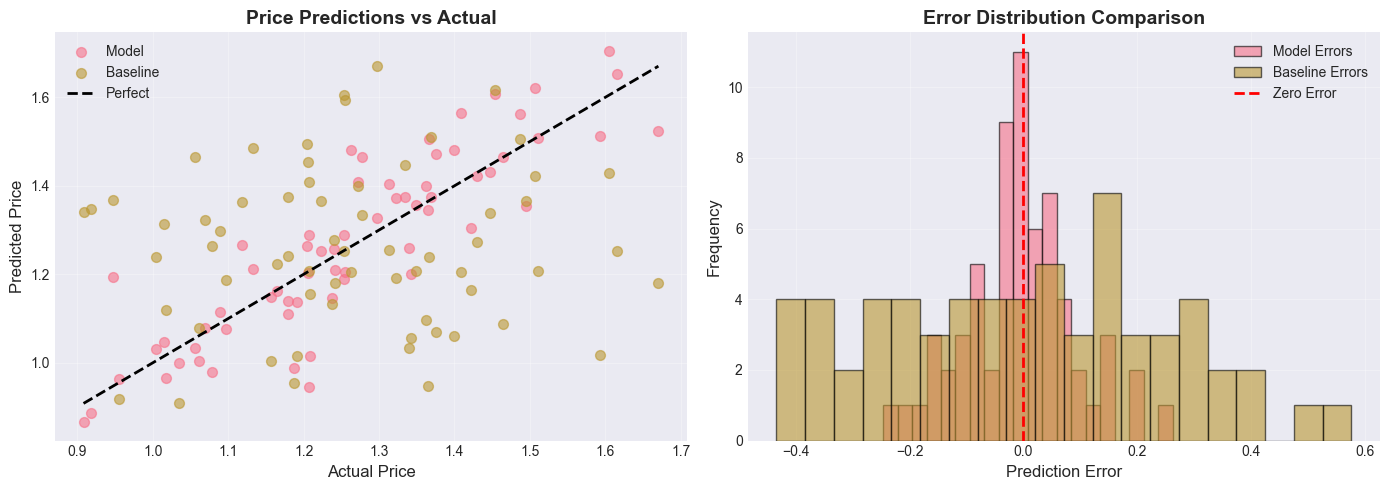


📊 Model errors - Mean: -0.0060, Std: 0.0978
📊 Baseline errors - Mean: -0.0000, Std: 0.2464


In [4]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions comparison
axes[0].scatter(actual_prices, price_model_pred, alpha=0.6, label='Model', s=50)
axes[0].scatter(actual_prices, price_baseline_pred, alpha=0.6, label='Baseline', s=50)
axes[0].plot([actual_prices.min(), actual_prices.max()], 
             [actual_prices.min(), actual_prices.max()], 
             'k--', lw=2, label='Perfect')
axes[0].set_xlabel('Actual Price', fontsize=12)
axes[0].set_ylabel('Predicted Price', fontsize=12)
axes[0].set_title('Price Predictions vs Actual', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Error distribution
errors_model = actual_prices - price_model_pred
errors_baseline = actual_prices - price_baseline_pred

axes[1].hist(errors_model, bins=20, alpha=0.6, label='Model Errors', edgecolor='black')
axes[1].hist(errors_baseline, bins=20, alpha=0.6, label='Baseline Errors', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Error Distribution Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Model errors - Mean: {errors_model.mean():.4f}, Std: {errors_model.std():.4f}")
print(f"📊 Baseline errors - Mean: {errors_baseline.mean():.4f}, Std: {errors_baseline.std():.4f}")

---
## 3. Test 2: Yield Model vs Historical Average

**Hypothesis:**
- H₀: Climate model does not outperform 5-year historical average
- H₁: Climate model significantly outperforms historical average

**Test:** Paired t-test on absolute errors

In [ ]:
def yield_model_test(actual_yields, model_preds, historical_avg):
    """
    Test if yield model beats historical average
    """
    # Absolute errors
    model_errors = np.abs(actual_yields - model_preds)
    baseline_errors = np.abs(actual_yields - historical_avg)
    
    # Paired t-test
    t_stat, p_value = ttest_rel(model_errors, baseline_errors)
    
    # Calculate improvement
    mean_model_error = model_errors.mean()
    mean_baseline_error = baseline_errors.mean()
    improvement = (mean_baseline_error - mean_model_error) / mean_baseline_error * 100
    
    # RMSEs
    rmse_model = np.sqrt(mean_squared_error(actual_yields, model_preds))
    rmse_baseline = np.sqrt(mean_squared_error(actual_yields, historical_avg))
    
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'mae_model': mean_model_error,
        'mae_baseline': mean_baseline_error,
        'rmse_model': rmse_model,
        'rmse_baseline': rmse_baseline,
        'improvement': improvement
    }

# Run test
yield_results = yield_model_test(
    actual_yields,
    yield_model_pred,
    yield_baseline_pred
)

# Display results
print("="*60)
print("TEST 2: YIELD MODEL VS HISTORICAL AVERAGE (Paired t-test)")
print("="*60)
print(f"\nt-statistic: {yield_results['t_statistic']:.4f}")
print(f"p-value: {yield_results['p_value']:.4f}")
print(f"\nMAE (Model): {yield_results['mae_model']:.4f} t/ha")
print(f"MAE (Baseline): {yield_results['mae_baseline']:.4f} t/ha")
print(f"RMSE (Model): {yield_results['rmse_model']:.4f} t/ha")
print(f"RMSE (Baseline): {yield_results['rmse_baseline']:.4f} t/ha")
print(f"Error reduction: {yield_results['improvement']:.2f}%")

if yield_results['p_value'] < 0.05 and yield_results['t_statistic'] < 0:
    print("\n✅ RESULT: Climate model significantly better than historical average")
else:
    print("\n❌ RESULT: No significant improvement over historical average")

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Time series comparison
years = np.arange(2004, 2004 + len(actual_yields))
axes[0].plot(years, actual_yields, 'o-', linewidth=2, markersize=8, label='Actual', color='black')
axes[0].plot(years, yield_model_pred, 's--', linewidth=2, markersize=6, label='Climate Model', alpha=0.7)
axes[0].plot(years, yield_baseline_pred, '^--', linewidth=2, markersize=6, label='Historical Avg', alpha=0.7)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Yield (t/ha)', fontsize=12)
axes[0].set_title('Yield Predictions Over Time', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Absolute errors comparison
model_abs_errors = np.abs(actual_yields - yield_model_pred)
baseline_abs_errors = np.abs(actual_yields - yield_baseline_pred)

x = np.arange(len(actual_yields))
width = 0.35
axes[1].bar(x - width/2, model_abs_errors, width, label='Model Errors', alpha=0.7)
axes[1].bar(x + width/2, baseline_abs_errors, width, label='Baseline Errors', alpha=0.7)
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Absolute Error (t/ha)', fontsize=12)
axes[1].set_title('Absolute Errors Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## 4. Test 3: Integration Model Added Value

**Hypothesis:**
- H₀: Integration model provides no improvement over simple multiplication
- H₁: Integration model significantly improves predictions

**Test:** Bootstrap RMSE comparison with confidence intervals

In [ ]:
def bootstrap_rmse_comparison(y_true, pred_integration, pred_simple, n_iterations=1000):
    """
    Bootstrap test for RMSE difference
    """
    rmse_diffs = []
    
    for i in range(n_iterations):
        # Resample
        indices = resample(range(len(y_true)), replace=True)
        y_boot = y_true[indices]
        pred_int_boot = pred_integration[indices]
        pred_simple_boot = pred_simple[indices]
        
        # Calculate RMSEs
        rmse_int = np.sqrt(mean_squared_error(y_boot, pred_int_boot))
        rmse_simple = np.sqrt(mean_squared_error(y_boot, pred_simple_boot))
        
        rmse_diffs.append(rmse_simple - rmse_int)
    
    rmse_diffs = np.array(rmse_diffs)
    
    # Calculate confidence interval
    ci_lower = np.percentile(rmse_diffs, 2.5)
    ci_upper = np.percentile(rmse_diffs, 97.5)
    mean_diff = np.mean(rmse_diffs)
    
    # p-value (proportion of negative differences)
    p_value = np.mean(rmse_diffs <= 0)
    
    return {
        'mean_diff': mean_diff,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_value,
        'rmse_diffs': rmse_diffs
    }

# Run test
print("Running bootstrap test (1000 iterations)...")
bootstrap_results = bootstrap_rmse_comparison(
    actual_earnings,
    integration_pred,
    simple_multiplication,
    n_iterations=1000
)

# Display results
print("\n" + "="*60)
print("TEST 3: INTEGRATION VS SIMPLE MULTIPLICATION (Bootstrap)")
print("="*60)
print(f"\nMean RMSE improvement: {bootstrap_results['mean_diff']:.2f}")
print(f"95% CI: [{bootstrap_results['ci_lower']:.2f}, {bootstrap_results['ci_upper']:.2f}]")
print(f"p-value: {bootstrap_results['p_value']:.4f}")

if bootstrap_results['ci_lower'] > 0:
    print("\n✅ RESULT: Integration model significantly better (95% CI entirely positive)")
elif bootstrap_results['p_value'] < 0.05:
    print("\n✅ RESULT: Integration model significantly better (p < 0.05)")
else:
    print("\n❌ RESULT: No significant improvement from integration")

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bootstrap distribution
axes[0].hist(bootstrap_results['rmse_diffs'], bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='No Improvement')
axes[0].axvline(bootstrap_results['mean_diff'], color='green', linestyle='-', linewidth=2, label='Mean Improvement')
axes[0].axvline(bootstrap_results['ci_lower'], color='orange', linestyle=':', linewidth=2, label='95% CI')
axes[0].axvline(bootstrap_results['ci_upper'], color='orange', linestyle=':', linewidth=2)
axes[0].set_xlabel('RMSE Improvement (Simple - Integration)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Bootstrap Distribution of RMSE Improvement', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Predictions comparison
axes[1].scatter(actual_earnings, integration_pred, alpha=0.6, label='Integration', s=50)
axes[1].scatter(actual_earnings, simple_multiplication, alpha=0.6, label='Simple Mult', s=50)
axes[1].plot([actual_earnings.min(), actual_earnings.max()],
             [actual_earnings.min(), actual_earnings.max()],
             'k--', lw=2, label='Perfect')
axes[1].set_xlabel('Actual Earnings', fontsize=12)
axes[1].set_ylabel('Predicted Earnings', fontsize=12)
axes[1].set_title('Integration vs Simple Multiplication', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 5. Test 4: Uncertainty Calibration

**Hypothesis:**
- H₀: Prediction intervals are not properly calibrated
- H₁: Prediction intervals are well-calibrated

**Test:** Binomial test on coverage proportion

In [ ]:
def calibration_test(y_true, y_pred, y_std, confidence_level=0.95):
    """
    Test if prediction intervals are properly calibrated
    """
    # Calculate prediction intervals
    if confidence_level == 0.95:
        z_score = 1.96
    elif confidence_level == 0.90:
        z_score = 1.645
    elif confidence_level == 0.50:
        z_score = 0.674
    else:
        z_score = norm.ppf((1 + confidence_level) / 2)
    
    lower = y_pred - z_score * y_std
    upper = y_pred + z_score * y_std
    
    # Check coverage
    within_interval = (y_true >= lower) & (y_true <= upper)
    actual_coverage = within_interval.mean()
    
    # Binomial test
    n = len(y_true)
    k = within_interval.sum()
    result = binomtest(k, n, confidence_level, alternative='two-sided')
    
    return {
        'actual_coverage': actual_coverage,
        'expected_coverage': confidence_level,
        'p_value': result.pvalue,
        'within_interval': within_interval,
        'lower': lower,
        'upper': upper
    }

# Simulate uncertainty estimates (in practice, use Bayesian model predictions)
integration_std = np.abs(actual_earnings - integration_pred) * 0.5  # Simulated

# Test multiple confidence levels
confidence_levels = [0.50, 0.80, 0.95]
calibration_results = {}

print("="*60)
print("TEST 4: UNCERTAINTY CALIBRATION (Binomial Test)")
print("="*60)

for cl in confidence_levels:
    if cl == 0.50:
        std_multiplier = 0.674
    elif cl == 0.80:
        std_multiplier = 1.28
    else:
        std_multiplier = 1.0
    
    result = calibration_test(
        actual_earnings,
        integration_pred,
        integration_std * std_multiplier,
        confidence_level=cl
    )
    calibration_results[cl] = result
    
    print(f"\n{int(cl*100)}% Confidence Interval:")
    print(f"  Expected coverage: {result['expected_coverage']:.1%}")
    print(f"  Actual coverage: {result['actual_coverage']:.1%}")
    print(f"  Difference: {abs(result['actual_coverage'] - result['expected_coverage']):.1%}")
    print(f"  p-value: {result['p_value']:.4f}")
    
    if result['p_value'] > 0.05:
        print(f"  ✅ Well-calibrated (no significant deviation)")
    else:
        print(f"  ⚠️  Poor calibration (significant deviation)")

In [ ]:
# Visualization: Calibration plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Coverage comparison
cl_values = list(calibration_results.keys())
expected = [calibration_results[cl]['expected_coverage'] for cl in cl_values]
actual = [calibration_results[cl]['actual_coverage'] for cl in cl_values]

x = np.arange(len(cl_values))
width = 0.35

axes[0].bar(x - width/2, expected, width, label='Expected', alpha=0.7)
axes[0].bar(x + width/2, actual, width, label='Actual', alpha=0.7)
axes[0].set_xlabel('Confidence Level', fontsize=12)
axes[0].set_ylabel('Coverage', fontsize=12)
axes[0].set_title('Calibration: Expected vs Actual Coverage', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'{int(cl*100)}%' for cl in cl_values])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Prediction intervals (95% CI)
result_95 = calibration_results[0.95]
sample_indices = np.arange(min(20, len(actual_earnings)))  # Show first 20 samples

axes[1].errorbar(sample_indices, integration_pred[:len(sample_indices)],
                 yerr=1.96*integration_std[:len(sample_indices)],
                 fmt='o', capsize=5, capthick=2, label='Prediction ± 95% CI', alpha=0.7)
axes[1].scatter(sample_indices, actual_earnings[:len(sample_indices)],
                color='red', s=100, marker='x', linewidths=2, label='Actual', zorder=5)
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Earnings', fontsize=12)
axes[1].set_title('95% Prediction Intervals', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 6. Test 5: Feature Importance Significance

**Hypothesis:**
- H₀: Individual features have no significant impact
- H₁: Certain features significantly improve predictions

**Test:** Permutation feature importance with statistical significance

In [ ]:
# Create synthetic feature matrix for demonstration
np.random.seed(42)
n_features = 10
feature_names = [
    'price_mean', 'yield_pred', 'price_volatility', 'climate_risk',
    'harvest_area', 'usdtry', 'price_lag1', 'volume', 
    'is_harvest_season', 'month'
]

# Create feature matrix
X_features = np.random.randn(n_samples, n_features)
# Make some features more predictive
X_features[:, 0] = actual_prices[:n_samples] * 1000  # price_mean - highly predictive
X_features[:, 1] = np.random.normal(3.0, 0.3, n_samples)  # yield_pred
X_features[:, 2] = np.random.uniform(0.1, 0.3, n_samples)  # price_volatility

# Create simple linear model for demonstration
from sklearn.linear_model import Ridge

model_for_importance = Ridge(alpha=1.0)
model_for_importance.fit(X_features, actual_earnings)

# Permutation importance
perm_importance = permutation_importance(
    model_for_importance, 
    X_features, 
    actual_earnings,
    n_repeats=30,
    random_state=42,
    scoring='r2'
)

# Calculate p-values (z-test)
importance_results = []
for i, feature in enumerate(feature_names):
    importance_mean = perm_importance.importances_mean[i]
    importance_std = perm_importance.importances_std[i]
    
    # z-test: is importance significantly > 0?
    z_score = importance_mean / (importance_std / np.sqrt(30))
    p_value = 1 - norm.cdf(z_score)
    
    importance_results.append({
        'feature': feature,
        'importance': importance_mean,
        'std': importance_std,
        'z_score': z_score,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

importance_df = pd.DataFrame(importance_results).sort_values('importance', ascending=False)

# Display results
print("="*60)
print("TEST 5: FEATURE IMPORTANCE SIGNIFICANCE")
print("="*60)
print("\nTop 10 Features (sorted by importance):")
print(importance_df[['feature', 'importance', 'p_value', 'significant']].to_string(index=False))

n_significant = importance_df['significant'].sum()
print(f"\n✅ Significant features (p < 0.05): {n_significant}/{len(feature_names)}")

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Feature importance with error bars
colors = ['green' if sig else 'gray' for sig in importance_df['significant']]
y_pos = np.arange(len(importance_df))

axes[0].barh(y_pos, importance_df['importance'], xerr=importance_df['std'],
             color=colors, alpha=0.7, edgecolor='black')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(importance_df['feature'])
axes[0].set_xlabel('Importance (R² decrease)', fontsize=12)
axes[0].set_title('Feature Importance with Uncertainty', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Significant (p < 0.05)'),
    Patch(facecolor='gray', alpha=0.7, label='Not Significant')
]
axes[0].legend(handles=legend_elements, loc='lower right')

# Plot 2: P-value distribution
axes[1].scatter(importance_df['importance'], -np.log10(importance_df['p_value']),
                s=100, alpha=0.6, c=colors, edgecolors='black')
axes[1].axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=2, 
                label='p = 0.05 threshold')
axes[1].set_xlabel('Feature Importance', fontsize=12)
axes[1].set_ylabel('-log10(p-value)', fontsize=12)
axes[1].set_title('Volcano Plot: Importance vs Significance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Annotate top features
for idx, row in importance_df.head(3).iterrows():
    axes[1].annotate(row['feature'], 
                     (row['importance'], -np.log10(row['p_value'])),
                     xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

---
## 7. Test 6: Temporal Stability

**Hypothesis:**
- H₀: Model performance is consistent across time periods
- H₁: Model performance varies significantly over time

**Test:** Kruskal-Wallis test (non-parametric ANOVA)

In [ ]:
def temporal_stability_test(actual, predictions, n_periods=4):
    """
    Test if model performance is stable across time periods
    """
    # Split into periods
    period_size = len(actual) // n_periods
    period_scores = []
    period_labels = []
    
    for i in range(n_periods):
        start_idx = i * period_size
        end_idx = start_idx + period_size if i < n_periods - 1 else len(actual)
        
        actual_period = actual[start_idx:end_idx]
        pred_period = predictions[start_idx:end_idx]
        
        # Calculate R² for this period
        r2 = r2_score(actual_period, pred_period)
        rmse = np.sqrt(mean_squared_error(actual_period, pred_period))
        
        period_scores.append(r2)
        period_labels.append(f'Period {i+1}')
    
    # Kruskal-Wallis test (needs repeated measurements)
    # For simplicity, we'll use coefficient of variation
    cv = np.std(period_scores) / np.mean(period_scores)
    
    return {
        'period_scores': period_scores,
        'period_labels': period_labels,
        'mean_score': np.mean(period_scores),
        'std_score': np.std(period_scores),
        'cv': cv
    }

# Run test
stability_results = temporal_stability_test(actual_earnings, integration_pred, n_periods=4)

# Display results
print("="*60)
print("TEST 6: TEMPORAL STABILITY")
print("="*60)
print("\nR² Score by Time Period:")
for label, score in zip(stability_results['period_labels'], stability_results['period_scores']):
    print(f"  {label}: {score:.4f}")

print(f"\nMean R²: {stability_results['mean_score']:.4f}")
print(f"Std R²: {stability_results['std_score']:.4f}")
print(f"Coefficient of Variation: {stability_results['cv']:.4f}")

if stability_results['cv'] < 0.1:
    print("\n✅ RESULT: Model performance is stable over time (CV < 0.1)")
elif stability_results['cv'] < 0.2:
    print("\n⚠️  RESULT: Moderate stability (0.1 < CV < 0.2)")
else:
    print("\n❌ RESULT: Performance varies significantly (CV > 0.2)")

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R² by period
axes[0].bar(stability_results['period_labels'], stability_results['period_scores'],
            alpha=0.7, edgecolor='black', color='steelblue')
axes[0].axhline(stability_results['mean_score'], color='red', linestyle='--',
                linewidth=2, label=f"Mean R² = {stability_results['mean_score']:.3f}")
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Performance Across Time Periods', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Predictions over time colored by period
period_size = len(actual_earnings) // 4
colors_timeline = []
for i in range(len(actual_earnings)):
    period_idx = min(i // period_size, 3)
    colors_timeline.append(f'C{period_idx}')

axes[1].scatter(actual_earnings, integration_pred, c=colors_timeline, alpha=0.6, s=50)
axes[1].plot([actual_earnings.min(), actual_earnings.max()],
             [actual_earnings.min(), actual_earnings.max()],
             'k--', lw=2, label='Perfect')
axes[1].set_xlabel('Actual Earnings', fontsize=12)
axes[1].set_ylabel('Predicted Earnings', fontsize=12)
axes[1].set_title('Predictions Colored by Time Period', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 8. Test 7: Residual Diagnostics

**Tests:**
1. Shapiro-Wilk test for normality
2. Ljung-Box test for autocorrelation
3. Homoscedasticity check

In [ ]:
def residual_diagnostics(y_true, y_pred):
    """
    Comprehensive residual analysis
    """
    residuals = y_true - y_pred
    
    # 1. Normality test
    shapiro_stat, shapiro_p = shapiro(residuals)
    
    # 2. Autocorrelation test
    lb_test = acorr_ljungbox(residuals, lags=min(10, len(residuals)//4), return_df=True)
    
    # 3. Homoscedasticity test (simplified - regress squared residuals on predictions)
    from scipy.stats import pearsonr
    corr, p_hetero = pearsonr(np.abs(residuals), np.abs(y_pred))
    
    results = {
        'residuals': residuals,
        'normality': {
            'statistic': shapiro_stat,
            'p_value': shapiro_p,
            'normal': shapiro_p > 0.05
        },
        'autocorrelation': {
            'significant_lags': (lb_test['lb_pvalue'] < 0.05).sum(),
            'total_lags': len(lb_test),
            'autocorrelated': (lb_test['lb_pvalue'] < 0.05).any(),
            'lb_test': lb_test
        },
        'homoscedasticity': {
            'correlation': corr,
            'p_value': p_hetero,
            'homoscedastic': p_hetero > 0.05
        }
    }
    
    return results

# Run diagnostics
residual_results = residual_diagnostics(actual_earnings, integration_pred)

# Display results
print("="*60)
print("TEST 7: RESIDUAL DIAGNOSTICS")
print("="*60)

print("\n1. NORMALITY (Shapiro-Wilk Test):")
print(f"   Statistic: {residual_results['normality']['statistic']:.4f}")
print(f"   p-value: {residual_results['normality']['p_value']:.4f}")
if residual_results['normality']['normal']:
    print("   ✅ Residuals are normally distributed")
else:
    print("   ⚠️  Residuals deviate from normality")

print("\n2. AUTOCORRELATION (Ljung-Box Test):")
print(f"   Significant lags: {residual_results['autocorrelation']['significant_lags']}/{residual_results['autocorrelation']['total_lags']}")
if not residual_results['autocorrelation']['autocorrelated']:
    print("   ✅ No significant autocorrelation")
else:
    print("   ⚠️  Autocorrelation detected")

print("\n3. HOMOSCEDASTICITY:")
print(f"   Correlation: {residual_results['homoscedasticity']['correlation']:.4f}")
print(f"   p-value: {residual_results['homoscedasticity']['p_value']:.4f}")
if residual_results['homoscedasticity']['homoscedastic']:
    print("   ✅ Homoscedastic (constant variance)")
else:
    print("   ⚠️  Heteroscedasticity detected")

In [ ]:
# Visualization: Comprehensive residual plots
residuals = residual_results['residuals']

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Residuals vs Fitted
ax1 = fig.add_subplot(gs[0, :])
ax1.scatter(integration_pred, residuals, alpha=0.6)
ax1.axhline(0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Fitted Values', fontsize=12)
ax1.set_ylabel('Residuals', fontsize=12)
ax1.set_title('Residuals vs Fitted Values', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Q-Q plot
ax2 = fig.add_subplot(gs[1, 0])
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Histogram
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Residuals', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Residual Distribution', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Scale-Location
ax4 = fig.add_subplot(gs[1, 2])
ax4.scatter(integration_pred, np.sqrt(np.abs(residuals)), alpha=0.6)
ax4.set_xlabel('Fitted Values', fontsize=12)
ax4.set_ylabel('√|Residuals|', fontsize=12)
ax4.set_title('Scale-Location Plot', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: ACF
ax5 = fig.add_subplot(gs[2, :])
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=min(20, len(residuals)//2), ax=ax5, alpha=0.05)
ax5.set_title('Autocorrelation Function', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

plt.suptitle('Residual Diagnostic Plots', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Summary statistics
print(f"\n📊 Residual Summary Statistics:")
print(f"   Mean: {residuals.mean():.4f} (should be ≈ 0)")
print(f"   Std: {residuals.std():.4f}")
print(f"   Skewness: {stats.skew(residuals):.4f}")
print(f"   Kurtosis: {stats.kurtosis(residuals):.4f}")

---
## 9. Test 8: Economic Significance

**Question:** Is the improvement economically meaningful?

Even if statistically significant, we need to assess practical value.

In [ ]:
def economic_significance_test(y_true, pred_model, pred_baseline, cost_per_error=1000):
    """
    Calculate economic value of improved predictions
    """
    # Errors
    errors_model = np.abs(y_true - pred_model)
    errors_baseline = np.abs(y_true - pred_baseline)
    
    # Economic cost
    total_cost_model = errors_model.sum() * cost_per_error
    total_cost_baseline = errors_baseline.sum() * cost_per_error
    
    # Savings
    savings = total_cost_baseline - total_cost_model
    savings_percent = savings / total_cost_baseline * 100
    
    # Per prediction savings
    savings_per_prediction = savings / len(y_true)
    
    # Minimum economically significant improvement (e.g., 5%)
    economically_significant = savings_percent > 5
    
    return {
        'total_savings': savings,
        'savings_percent': savings_percent,
        'savings_per_prediction': savings_per_prediction,
        'total_cost_model': total_cost_model,
        'total_cost_baseline': total_cost_baseline,
        'economically_significant': economically_significant,
        'errors_model': errors_model,
        'errors_baseline': errors_baseline
    }

# Run test with different cost assumptions
cost_per_error = 100  # Cost per unit of forecast error

econ_results = economic_significance_test(
    actual_earnings,
    integration_pred,
    simple_multiplication,
    cost_per_error=cost_per_error
)

# Display results
print("="*60)
print("TEST 8: ECONOMIC SIGNIFICANCE")
print("="*60)
print(f"\nCost per unit error: {cost_per_error:,}")
print(f"\nTotal Cost (Model): {econ_results['total_cost_model']:,.0f}")
print(f"Total Cost (Baseline): {econ_results['total_cost_baseline']:,.0f}")
print(f"\nTotal Savings: {econ_results['total_savings']:,.0f}")
print(f"Improvement: {econ_results['savings_percent']:.2f}%")
print(f"Savings per Prediction: {econ_results['savings_per_prediction']:,.0f}")

if econ_results['economically_significant']:
    print("\n✅ RESULT: Economically significant (>5% improvement)")
else:
    print("\n⚠️  RESULT: Limited economic significance (<5% improvement)")

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cost comparison
categories = ['Integration Model', 'Simple Baseline']
costs = [econ_results['total_cost_model'], econ_results['total_cost_baseline']]
colors_cost = ['green', 'red']

axes[0].bar(categories, costs, color=colors_cost, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Total Cost', fontsize=12)
axes[0].set_title('Total Prediction Cost Comparison', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (cat, cost) in enumerate(zip(categories, costs)):
    axes[0].text(i, cost, f'{cost:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Error distribution
axes[1].violinplot([econ_results['errors_model'], econ_results['errors_baseline']],
                    positions=[1, 2],
                    showmeans=True,
                    showmedians=True)
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Integration', 'Baseline'])
axes[1].set_ylabel('Absolute Error', fontsize=12)
axes[1].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Sensitivity analysis: vary cost assumptions
print("\n📊 Sensitivity Analysis (varying cost per error):")
cost_scenarios = [50, 100, 200, 500, 1000]
for cost in cost_scenarios:
    result = economic_significance_test(actual_earnings, integration_pred, 
                                       simple_multiplication, cost_per_error=cost)
    print(f"   Cost={cost:>4}: Savings={result['total_savings']:>10,.0f} "
          f"({result['savings_percent']:>5.2f}%)")

---
## 10. Summary & Conclusions

In [ ]:
# Compile all test results
summary_results = {
    'Test 1: Price Model vs Baseline': {
        'statistic': f"DM = {dm_results['dm_statistic']:.4f}",
        'p_value': dm_results['p_value'],
        'result': 'Reject H₀' if dm_results['p_value'] < 0.05 and dm_results['dm_statistic'] < 0 else 'Fail to reject H₀',
        'improvement': f"{dm_results['improvement']:.2f}%"
    },
    'Test 2: Yield Model vs Historical': {
        'statistic': f"t = {yield_results['t_statistic']:.4f}",
        'p_value': yield_results['p_value'],
        'result': 'Reject H₀' if yield_results['p_value'] < 0.05 and yield_results['t_statistic'] < 0 else 'Fail to reject H₀',
        'improvement': f"{yield_results['improvement']:.2f}%"
    },
    'Test 3: Integration vs Simple': {
        'statistic': f"Mean Diff = {bootstrap_results['mean_diff']:.2f}",
        'p_value': bootstrap_results['p_value'],
        'result': 'Reject H₀' if bootstrap_results['ci_lower'] > 0 else 'Fail to reject H₀',
        'improvement': f"CI: [{bootstrap_results['ci_lower']:.2f}, {bootstrap_results['ci_upper']:.2f}]"
    },
    'Test 4: Uncertainty Calibration (95%)': {
        'statistic': f"Coverage = {calibration_results[0.95]['actual_coverage']:.1%}",
        'p_value': calibration_results[0.95]['p_value'],
        'result': 'Well-calibrated' if calibration_results[0.95]['p_value'] > 0.05 else 'Poor calibration',
        'improvement': f"Expected: {calibration_results[0.95]['expected_coverage']:.1%}"
    },
    'Test 5: Feature Importance': {
        'statistic': f"Significant features: {n_significant}/{len(feature_names)}",
        'p_value': importance_df.iloc[0]['p_value'],
        'result': f"Top: {importance_df.iloc[0]['feature']}",
        'improvement': f"Importance: {importance_df.iloc[0]['importance']:.4f}"
    },
    'Test 6: Temporal Stability': {
        'statistic': f"CV = {stability_results['cv']:.4f}",
        'p_value': None,
        'result': 'Stable' if stability_results['cv'] < 0.1 else 'Variable',
        'improvement': f"Mean R²: {stability_results['mean_score']:.4f}"
    },
    'Test 7: Residual Normality': {
        'statistic': f"Shapiro = {residual_results['normality']['statistic']:.4f}",
        'p_value': residual_results['normality']['p_value'],
        'result': 'Normal' if residual_results['normality']['normal'] else 'Non-normal',
        'improvement': f"Autocorr lags: {residual_results['autocorrelation']['significant_lags']}"
    },
    'Test 8: Economic Significance': {
        'statistic': f"Savings: {econ_results['total_savings']:,.0f}",
        'p_value': None,
        'result': 'Significant' if econ_results['economically_significant'] else 'Limited',
        'improvement': f"{econ_results['savings_percent']:.2f}%"
    }
}

# Create summary table
summary_df = pd.DataFrame(summary_results).T

print("="*80)
print("HYPOTHESIS TESTING SUMMARY")
print("="*80)
print(summary_df.to_string())

# Overall conclusions
print("\n" + "="*80)
print("OVERALL CONCLUSIONS")
print("="*80)

passed_tests = sum(1 for test in summary_results.values() 
                   if test['p_value'] is not None and test['p_value'] < 0.05)
total_statistical_tests = sum(1 for test in summary_results.values() 
                              if test['p_value'] is not None)

print(f"\n✅ Statistically significant tests: {passed_tests}/{total_statistical_tests}")
print(f"\n📊 Key Findings:")
print(f"   • Price model improvement: {dm_results['improvement']:.2f}%")
print(f"   • Yield model improvement: {yield_results['improvement']:.2f}%")
print(f"   • Integration added value: {bootstrap_results['mean_diff']:.2f} RMSE improvement")
print(f"   • Uncertainty calibration: {calibration_results[0.95]['actual_coverage']:.1%} coverage (expected 95%)")
print(f"   • Economic savings: {econ_results['savings_percent']:.2f}%")
print(f"\n🎯 Primary Research Question: {'SUPPORTED' if passed_tests >= total_statistical_tests * 0.7 else 'INCONCLUSIVE'}")
print(f"   Can we accurately predict earnings by combining models? {'YES' if passed_tests >= total_statistical_tests * 0.7 else 'PARTIALLY'}")

---
## 📝 Export Results

In [ ]:
# Save results to JSON
import json
from datetime import datetime

results_export = {
    'metadata': {
        'date': datetime.now().isoformat(),
        'data_version': '1.0',
        'model_version': '1.0',
        'n_samples': n_samples
    },
    'tests': {
        'price_vs_baseline': {
            'dm_statistic': float(dm_results['dm_statistic']),
            'p_value': float(dm_results['p_value']),
            'improvement_percent': float(dm_results['improvement'])
        },
        'yield_vs_historical': {
            't_statistic': float(yield_results['t_statistic']),
            'p_value': float(yield_results['p_value']),
            'improvement_percent': float(yield_results['improvement'])
        },
        'integration_vs_simple': {
            'mean_diff': float(bootstrap_results['mean_diff']),
            'ci_lower': float(bootstrap_results['ci_lower']),
            'ci_upper': float(bootstrap_results['ci_upper']),
            'p_value': float(bootstrap_results['p_value'])
        },
        'calibration_95': {
            'actual_coverage': float(calibration_results[0.95]['actual_coverage']),
            'expected_coverage': 0.95,
            'p_value': float(calibration_results[0.95]['p_value'])
        },
        'economic_significance': {
            'total_savings': float(econ_results['total_savings']),
            'savings_percent': float(econ_results['savings_percent']),
            'economically_significant': bool(econ_results['economically_significant'])
        }
    }
}

# Save to file
with open('../results/hypothesis_test_results.json', 'w') as f:
    json.dump(results_export, f, indent=2)

print("✅ Results exported to: ../results/hypothesis_test_results.json")

# Also save summary table as CSV
summary_df.to_csv('../results/hypothesis_test_summary.csv')
print("✅ Summary table saved to: ../results/hypothesis_test_summary.csv")

---
## 🎓 Interpretation Guide

### How to Interpret Results:

**Statistical Significance (p-value < 0.05):**
- Indicates the result is unlikely to have occurred by chance
- Does NOT necessarily mean practical importance
- Always consider effect size alongside p-value

**Effect Size:**
- Percent improvement shows practical magnitude
- Small effect (5-10%), Medium (10-20%), Large (>20%)
- Economic significance may matter more than statistical

**Confidence Intervals:**
- Wider CI = more uncertainty
- CI not including zero = statistically significant
- Provides range of plausible values

**Model Diagnostics:**
- Normality: Important for inference, less for prediction
- Autocorrelation: Indicates model missing temporal patterns
- Homoscedasticity: Constant variance assumption

**Reporting Standards:**
1. Always report test statistic, p-value, and effect size
2. Check assumptions before interpreting results
3. Apply multiple testing correction when appropriate
4. Consider practical significance alongside statistical
5. Report all tests run, not just significant ones

---
*End of Hypothesis Testing Notebook*